/Users/rudi/miniconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rudi/miniconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rudi/miniconda3/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWa

For mouse1: Correlation for Early Sessions: -3.47e-01 with a p-value: 4.21e-07
For mouse1: Correlation for Later Sessions: -1.76e-01 with a p-value: 1.27e-07
Formouse1: Difference in correlations p-value: 0.018706414279300754
For mouse2: Correlation for Early Sessions: -4.42e-01 with a p-value: 1.67e-06
For mouse2: Correlation for Later Sessions: 2.77e-03 with a p-value: 9.48e-01
Formouse2: Difference in correlations p-value: 8.455135607876585e-06
For mouse3: Correlation for Early Sessions: -1.55e-01 with a p-value: 2.40e-02
For mouse3: Correlation for Later Sessions: 7.88e-02 with a p-value: 1.16e-02
Formouse3: Difference in correlations p-value: 0.0019801980517675233
For mouse4: Correlation for Early Sessions: -3.88e-01 with a p-value: 5.81e-09
For mouse4: Correlation for Later Sessions: -1.08e-01 with a p-value: 1.35e-02
Formouse4: Difference in correlations p-value: 0.0002665258153780048
For mouse5: Correlation for Early Sessions: -2.90e-01 with a p-value: 1.29e-04
For mouse5: Corr

/var/folders/b1/18y84q5j7xg_hmnnzfyc1rnw0000gn/T/ipykernel_71710/36496482.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


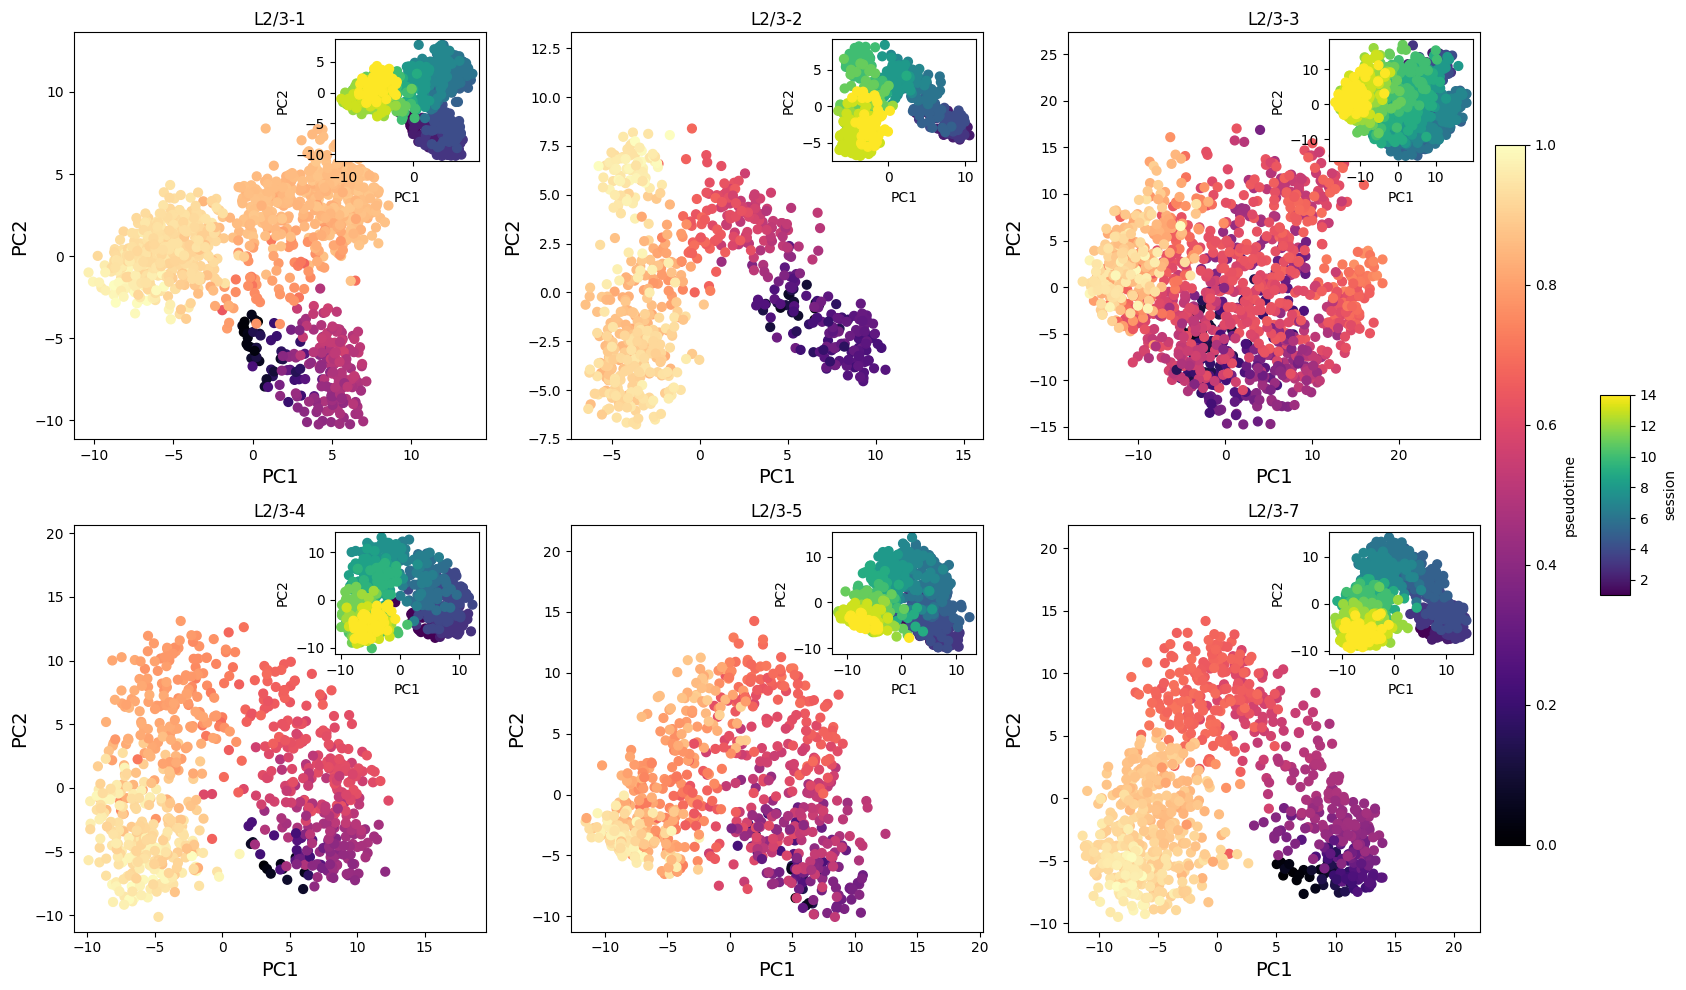

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from scipy.stats import t

#Perform pseudotime analysis and evaluate correlations

#Set run parameters
layer = 'L23'
group1 = [1, 2, 3, 4] #Early sessions definition
corrdf = pd.DataFrame(index=['Early', 'Later', 'p-value'])

# Create a list to store the scatter plot objects for each mouse
sc_plots = []

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, mouse in enumerate(['mouse1', 'mouse2', 'mouse3', 'mouse4', 'mouse5', 'mouse7']):

    # Read the data from Excel file
    datafile = layer+'/'+mouse+'.xlsx'
    df = pd.read_excel(datafile)

    # Extract data columns
    row_labels = df.iloc[:, 0]
    pc_data = df.iloc[:, 2:]  # Exclude the second column (rewardTime)
    pc12_data = df.iloc[:, 2:4] #Only PC1 and PC2

    # Create AnnData object
    adata = sc.AnnData(X=pc_data.values)
    adata.obs['session'] = row_labels.values
    adata.var_names = pc_data.columns.values

    # Create separate DataFrame for rewardTime
    reward_time = df.iloc[:, 1]
    reward_time_df = pd.DataFrame({'rewardTime': reward_time})

    # Add rewardTime as a separate DataFrame to AnnData object
    adata.obs['reward_time'] = reward_time_df.values

    # Add pc1+pc2 as a separate DataFrame to AnnData object
    adata.obsm['X_pca'] = pc12_data.values

    # Plot PCA
    #sc.pl.pca(adata, color=['session'])

    ## Pseudotime analysis

    #Get network embedding
    sc.pp.neighbors(adata, use_rep='X')

    #Assign root
    adata.uns['iroot'] = 0

    # Run diffusion pseudotime (DPT) analysis
    sc.tl.diffmap(adata, n_comps=10)
    sc.tl.dpt(adata, n_dcs=10)

    # Plot PCA
    # sc.pl.pca(adata, color=['dpt_pseudotime'])

    ##Compute Correlations
    # Create a boolean mask for early sessions (group 1) and late sessions (group 2)
    group_1_mask = adata.obs['session'].isin(group1)
    group_2_mask = ~group_1_mask

    # Filter 'reward_time' and 'dpt_pseudotime' using the group masks
    group_1_reward_time = adata.obs['reward_time'][group_1_mask]
    group_1_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_1_mask]

    group_2_reward_time = adata.obs['reward_time'][group_2_mask]
    group_2_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_2_mask]

    # Compute correlations
    corr_group_1 = np.corrcoef(group_1_reward_time, group_1_dpt_pseudotime)[0, 1]
    corr_group_2 = np.corrcoef(group_2_reward_time, group_2_dpt_pseudotime)[0, 1]

    ## Evaluate statistical significance
    # Sample sizes
    n_group_1 = len(group_1_reward_time)
    n_group_2 = len(group_2_reward_time)

    # Standard errors
    se_group_1 = np.sqrt((1 - corr_group_1 ** 2) / (n_group_1 - 2))
    se_group_2 = np.sqrt((1 - corr_group_2 ** 2) / (n_group_2 - 2))

    # t-statistics
    t_group_1 = corr_group_1 / se_group_1
    t_group_2 = corr_group_2 / se_group_2

    # p-values
    p_value_group_1 = 2 * (1 - t.cdf(np.abs(t_group_1), n_group_1 - 2))
    p_value_group_2 = 2 * (1 - t.cdf(np.abs(t_group_2), n_group_2 - 2))

    print("For "+mouse+": Correlation for Early Sessions: {:.2e} with a p-value: {:.2e}".format(corr_group_1, p_value_group_1))
    print("For "+mouse+": Correlation for Later Sessions: {:.2e} with a p-value: {:.2e}".format(corr_group_2, p_value_group_2))

    #Statistical test for correlation difference
    # Fisher's z-transform
    z_group_1 = 0.5 * np.log((1 + corr_group_1) / (1 - corr_group_1))
    z_group_2 = 0.5 * np.log((1 + corr_group_2) / (1 - corr_group_2))

    # Standard errors for z-transformed correlations
    se_group_1 = 1 / np.sqrt(n_group_1 - 3)
    se_group_2 = 1 / np.sqrt(n_group_2 - 3)

    # Standard error of the difference
    se_diff = np.sqrt(se_group_1**2 + se_group_2**2)

    # Test statistic
    t_diff = (z_group_1 - z_group_2) / se_diff

    # Degrees of freedom
    df_diff = n_group_1 + n_group_2 - 4

    # Two-tailed p-value
    p_value_diff = 2 * (1 - t.cdf(np.abs(t_diff), df_diff))

    print("For"+mouse+": Difference in correlations p-value:", p_value_diff)
    
    temp_df = pd.DataFrame({mouse: [corr_group_1, corr_group_2, p_value_diff]}, index=['Early', 'Later', 'p-value'])
    corrdf = pd.concat([corrdf, temp_df], axis=1)

    # Specify the subplot for the current mouse
    ax = axs.flatten()[i]
    plt.sca(ax)

    # Scatter plot of PC1 vs PC2 with dpt_pseudotime as color
    sc_plot = ax.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['dpt_pseudotime'], cmap='magma', s=40)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_title('L2/3-' + mouse[-1:])

    # Adjust x and y axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min, x_max + 0.25 * x_range)
    ax.set_ylim(y_min, y_max + 0.25 * y_range)

    # Add inset figure
    ax_inset = mpl_il.inset_axes(ax, width='35%', height='30%', loc='upper right')
    inset_sc_plot = ax_inset.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['session'], cmap='viridis', s=40)
    ax_inset.set_xlabel('PC1', fontsize=10)
    ax_inset.set_ylabel('PC2', fontsize=10)

    # Store the scatter plot object in the list
    sc_plots.append(sc_plot)


# Create a single color bar for the main figure (dpt_pseudotime)
cbar_main_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
cbar_main = fig.colorbar(sc_plots[0], cax=cbar_main_ax)
cbar_main.set_label('pseudotime')

# Create a single color bar for the inset figures (session)
cbar_inset_ax = fig.add_axes([1.07, 0.4, 0.02, 0.2])
cbar_inset = fig.colorbar(inset_sc_plot, cax=cbar_inset_ax)
cbar_inset.set_label('session')

# Adjust spacing between subplots
plt.tight_layout()

#save
figfile = 'figures/'+layer+'-dpt'
fig.savefig(figfile, dpi=300, bbox_inches='tight')

plt.show()

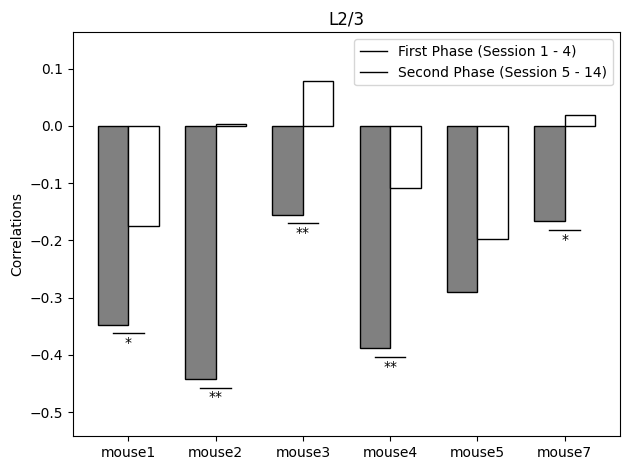

In [2]:
#Plot results of correlation analysis
# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the width for each bar
num_columns = corrdf.shape[1]
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(num_columns)

# Plot the bars
rects1 = ax.bar(index, corrdf.iloc[0], bar_width, color='gray', edgecolor='black', linewidth=1, label='Early')
rects2 = ax.bar(index + bar_width, corrdf.iloc[1], bar_width, color='white', edgecolor='black', linewidth=1, label='Later')

for i, val in enumerate(corrdf.iloc[2]):
    if 0.01 < val <= 0.05:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '*', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '*', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
    elif val <= 0.01:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '**', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '**', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)

        
# Customize the plot
ax.set_ylabel('Correlations')
ax.set_title('L2/3')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrdf.columns)

leg1 = 'First Phase (Session '+str(min(group1))+' - '+str(max(group1))+')'
leg2 = 'Second Phase (Session '+str(max(group1)+1)+' - '+str(row_labels.max())+')'
ax.legend([leg1, leg2])

# Adjust y-axis limits
y_min = min(corrdf.min()) - 0.1
y_max = max(corrdf.max()) - 0.1
ax.set_ylim([y_min, y_max])

# Save the output to file at 300 dpi
plt.tight_layout()
plt.savefig(layer+'.png', dpi=300)

# Display the plot
plt.show()

For mouse1: Correlation for Early Sessions: -1.73e-01 with a p-value: 7.26e-04
For mouse1: Correlation for Later Sessions: 1.70e-01 with a p-value: 7.96e-08
Formouse1: Difference in correlations p-value: 1.3964762679563592e-08
For mouse2: Correlation for Early Sessions: 2.04e-01 with a p-value: 1.03e-04
For mouse2: Correlation for Later Sessions: 3.43e-02 with a p-value: 2.61e-01
Formouse2: Difference in correlations p-value: 0.0049357230607742775
For mouse3: Correlation for Early Sessions: 7.59e-02 with a p-value: 1.45e-01
For mouse3: Correlation for Later Sessions: -1.27e-01 with a p-value: 1.79e-06
Formouse3: Difference in correlations p-value: 0.0005117479366028022
For mouse4: Correlation for Early Sessions: -1.42e-02 with a p-value: 7.76e-01
For mouse4: Correlation for Later Sessions: -7.72e-02 with a p-value: 1.15e-02
Formouse4: Difference in correlations p-value: 0.27948159691328467
For mouse5: Correlation for Early Sessions: -2.14e-01 with a p-value: 5.09e-05
For mouse5: Correl

/var/folders/b1/18y84q5j7xg_hmnnzfyc1rnw0000gn/T/ipykernel_71710/3466782325.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


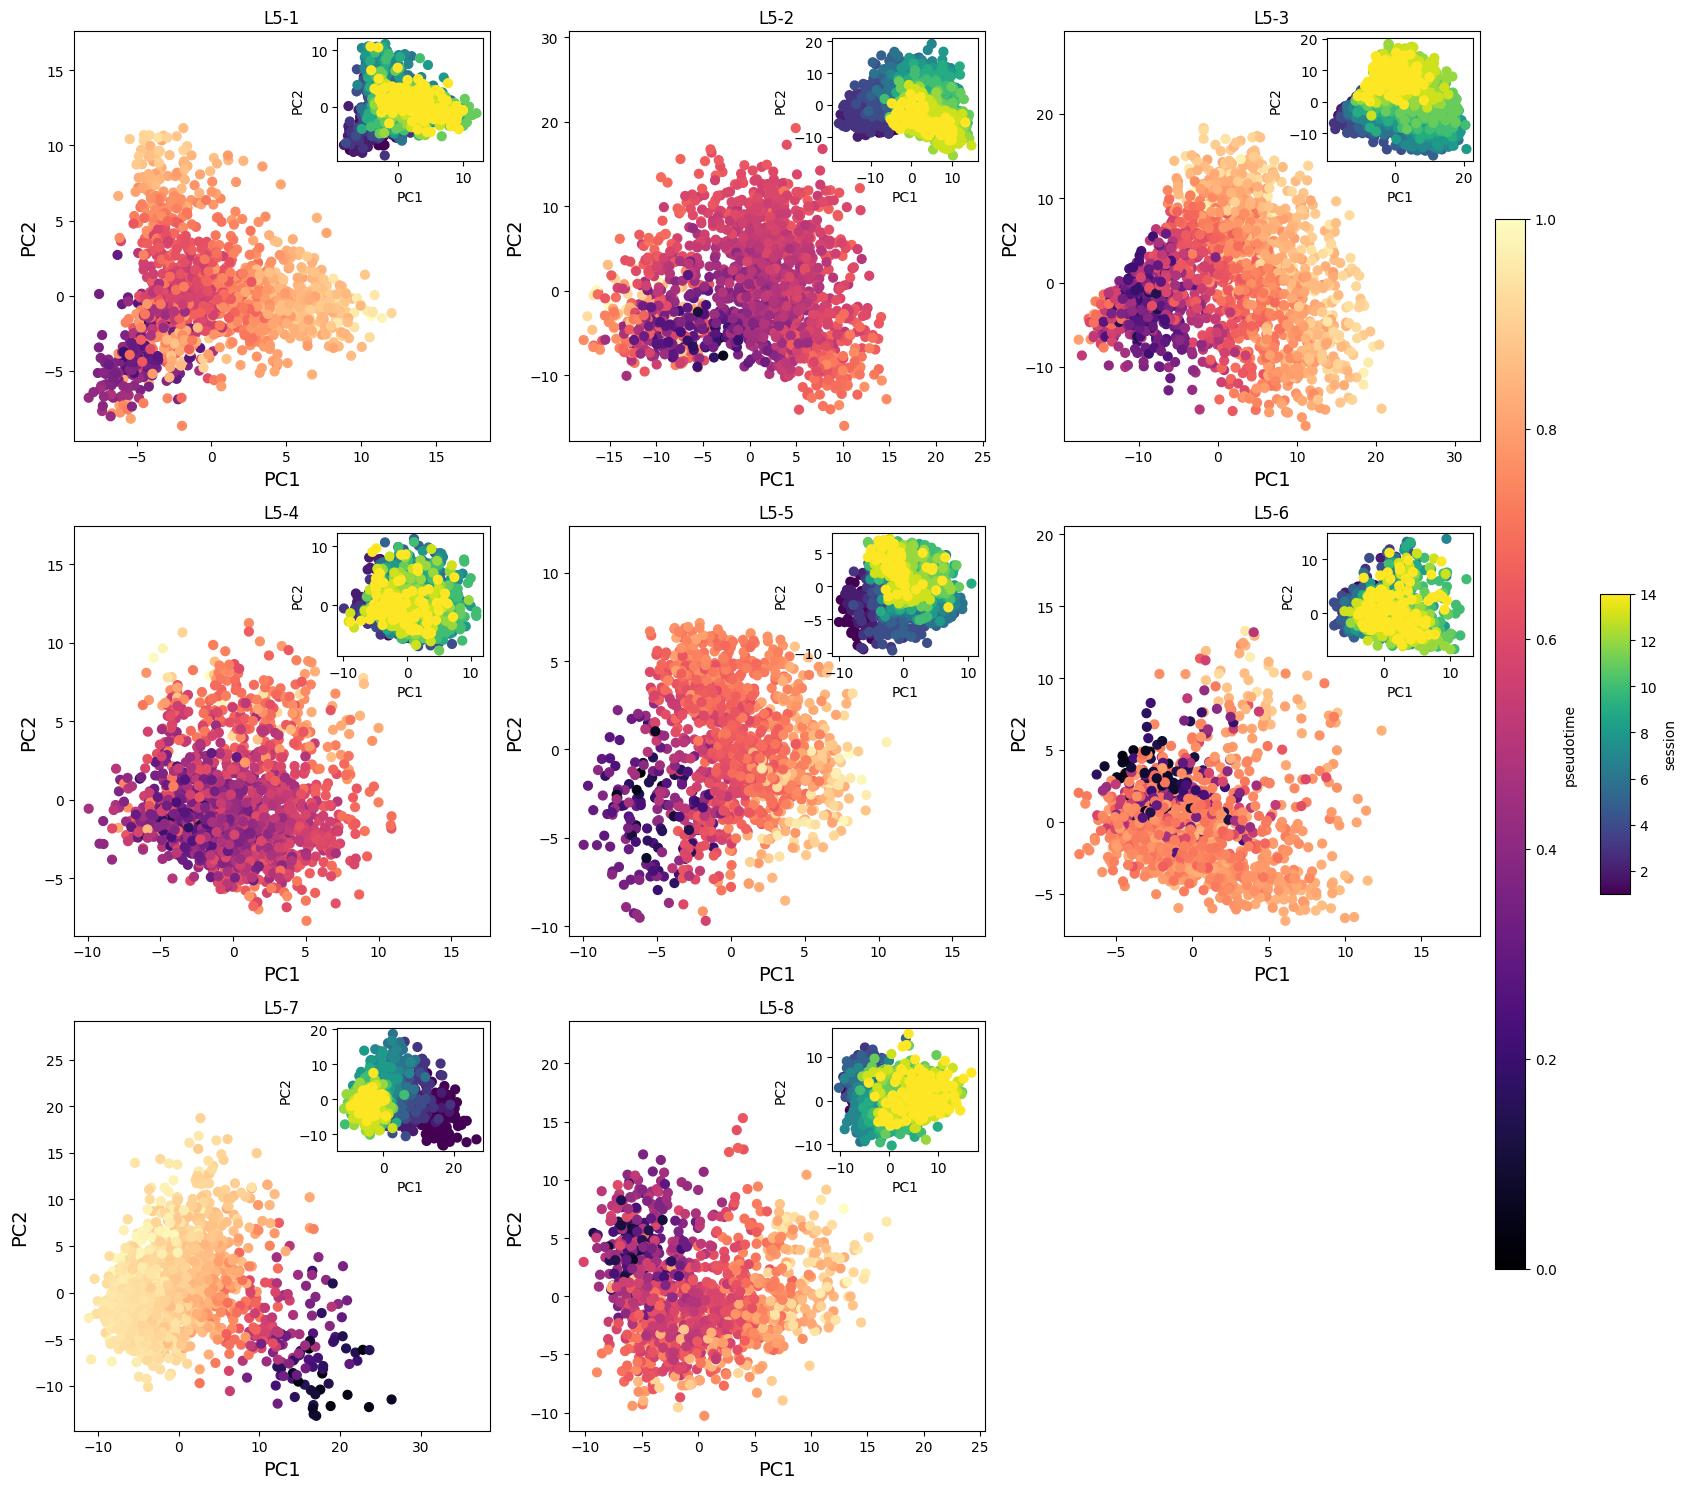

In [3]:
#Set run parameters
layer = 'L5'
group1 = [1, 2, 3, 4] #Early sessions definition
corrdf = pd.DataFrame(index=['Early', 'Later', 'p-value'])

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Create a list to store the scatter plot objects for each mouse
sc_plots = []

for i, mouse in enumerate(['mouse1', 'mouse2', 'mouse3', 'mouse4', 'mouse5', 'mouse6', 'mouse7', 'mouse8']):
    # Read the data from Excel file
    datafile = layer+'/'+mouse+'.xlsx'
    df = pd.read_excel(datafile)

    # Extract data columns
    row_labels = df.iloc[:, 0]
    pc_data = df.iloc[:, 2:]  # Exclude the second column (rewardTime)
    pc12_data = df.iloc[:, 2:4] #Only PC1 and PC2

    # Create AnnData object
    adata = sc.AnnData(X=pc_data.values)
    adata.obs['session'] = row_labels.values
    adata.var_names = pc_data.columns.values

    # Create separate DataFrame for rewardTime
    reward_time = df.iloc[:, 1]
    reward_time_df = pd.DataFrame({'rewardTime': reward_time})

    # Add rewardTime as a separate DataFrame to AnnData object
    adata.obs['reward_time'] = reward_time_df.values

    # Add pc1+pc2 as a separate DataFrame to AnnData object
    adata.obsm['X_pca'] = pc12_data.values

    # Plot PCA
    #sc.pl.pca(adata, color=['session'])

    ## Pseudotime analysis

    #Get network embedding
    sc.pp.neighbors(adata, use_rep='X')

    #Assign root
    adata.uns['iroot'] = 0

    # Run diffusion pseudotime (DPT) analysis
    sc.tl.diffmap(adata, n_comps=10)
    sc.tl.dpt(adata, n_dcs=10)

    # Plot PCA
    # sc.pl.pca(adata, color=['dpt_pseudotime'])

    ##Compute Correlations
    # Create a boolean mask for early sessions (group 1) and late sessions (group 2)
    group_1_mask = adata.obs['session'].isin(group1)
    group_2_mask = ~group_1_mask

    # Filter 'reward_time' and 'dpt_pseudotime' using the group masks
    group_1_reward_time = adata.obs['reward_time'][group_1_mask]
    group_1_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_1_mask]

    group_2_reward_time = adata.obs['reward_time'][group_2_mask]
    group_2_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_2_mask]

    # Compute correlations
    corr_group_1 = np.corrcoef(group_1_reward_time, group_1_dpt_pseudotime)[0, 1]
    corr_group_2 = np.corrcoef(group_2_reward_time, group_2_dpt_pseudotime)[0, 1]

    ## Evaluate statistical significance
    # Sample sizes
    n_group_1 = len(group_1_reward_time)
    n_group_2 = len(group_2_reward_time)

    # Standard errors
    se_group_1 = np.sqrt((1 - corr_group_1 ** 2) / (n_group_1 - 2))
    se_group_2 = np.sqrt((1 - corr_group_2 ** 2) / (n_group_2 - 2))

    # t-statistics
    t_group_1 = corr_group_1 / se_group_1
    t_group_2 = corr_group_2 / se_group_2

    # p-values
    p_value_group_1 = 2 * (1 - t.cdf(np.abs(t_group_1), n_group_1 - 2))
    p_value_group_2 = 2 * (1 - t.cdf(np.abs(t_group_2), n_group_2 - 2))

    print("For "+mouse+": Correlation for Early Sessions: {:.2e} with a p-value: {:.2e}".format(corr_group_1, p_value_group_1))
    print("For "+mouse+": Correlation for Later Sessions: {:.2e} with a p-value: {:.2e}".format(corr_group_2, p_value_group_2))

    #Statistical test for correlation difference
    # Fisher's z-transform
    z_group_1 = 0.5 * np.log((1 + corr_group_1) / (1 - corr_group_1))
    z_group_2 = 0.5 * np.log((1 + corr_group_2) / (1 - corr_group_2))

    # Standard errors for z-transformed correlations
    se_group_1 = 1 / np.sqrt(n_group_1 - 3)
    se_group_2 = 1 / np.sqrt(n_group_2 - 3)

    # Standard error of the difference
    se_diff = np.sqrt(se_group_1**2 + se_group_2**2)

    # Test statistic
    t_diff = (z_group_1 - z_group_2) / se_diff

    # Degrees of freedom
    df_diff = n_group_1 + n_group_2 - 4

    # Two-tailed p-value
    p_value_diff = 2 * (1 - t.cdf(np.abs(t_diff), df_diff))

    print("For"+mouse+": Difference in correlations p-value:", p_value_diff)
    
    temp_df = pd.DataFrame({mouse: [corr_group_1, corr_group_2, p_value_diff]}, index=['Early', 'Later', 'p-value'])
    corrdf = pd.concat([corrdf, temp_df], axis=1)

    # Specify the subplot for the current mouse
    ax = axs.flatten()[i]
    plt.sca(ax)

    # Scatter plot of PC1 vs PC2 with dpt_pseudotime as color
    sc_plot = ax.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['dpt_pseudotime'], cmap='magma', s=40)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_title('L5-' + mouse[-1:])

    # Adjust x and y axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min, x_max + 0.25 * x_range)
    ax.set_ylim(y_min, y_max + 0.25 * y_range)

    # Add inset figure
    ax_inset = mpl_il.inset_axes(ax, width='35%', height='30%', loc='upper right')
    inset_sc_plot = ax_inset.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['session'], cmap='viridis', s=40)
    ax_inset.set_xlabel('PC1', fontsize=10)
    ax_inset.set_ylabel('PC2', fontsize=10)

    # Store the scatter plot object in the list
    sc_plots.append(sc_plot)

# Remove the axis of the last subfigure
axs.flatten()[-1].axis('off')

# Create a single color bar for the main figure (dpt_pseudotime)
cbar_main_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
cbar_main = fig.colorbar(sc_plots[0], cax=cbar_main_ax)
cbar_main.set_label('pseudotime')

# Create a single color bar for the inset figures (session)
cbar_inset_ax = fig.add_axes([1.07, 0.4, 0.02, 0.2])
cbar_inset = fig.colorbar(inset_sc_plot, cax=cbar_inset_ax)
cbar_inset.set_label('session')


# Adjust spacing between subplots
plt.tight_layout()

#save
figfile = 'figures/'+layer+'-dpt'
fig.savefig(figfile, dpi=300, bbox_inches='tight')

plt.show()

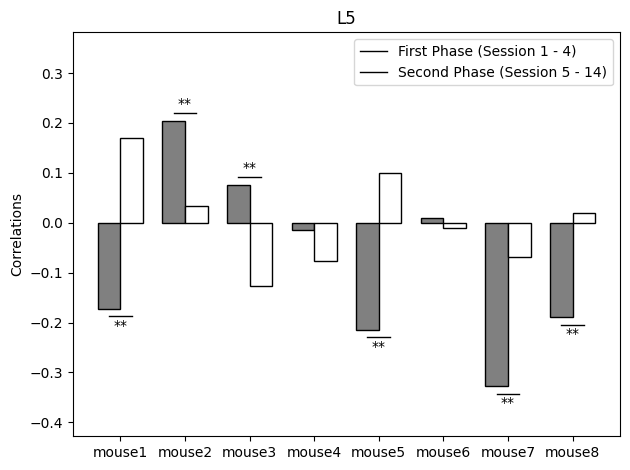

In [4]:
# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the width for each bar
num_columns = corrdf.shape[1]
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(num_columns)

# Plot the bars
rects1 = ax.bar(index, corrdf.iloc[0], bar_width, color='gray', edgecolor='black', linewidth=1, label='Early')
rects2 = ax.bar(index + bar_width, corrdf.iloc[1], bar_width, color='white', edgecolor='black', linewidth=1, label='Later')

for i, val in enumerate(corrdf.iloc[2]):
    if 0.01 < val <= 0.05:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '*', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '*', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
    elif val <= 0.01:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '**', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '**', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)

        
# Customize the plot
ax.set_ylabel('Correlations')
ax.set_title('L5')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrdf.columns)

leg1 = 'First Phase (Session '+str(min(group1))+' - '+str(max(group1))+')'
leg2 = 'Second Phase (Session '+str(max(group1)+1)+' - '+str(row_labels.max())+')'
ax.legend([leg1, leg2])

# Adjust y-axis limits
y_min = min(corrdf.min()) - 0.1
y_max = max(corrdf.max()) - 0.4
ax.set_ylim([y_min, y_max])

# Save the output to file at 300 dpi
plt.tight_layout()
plt.savefig(layer+'.png', dpi=300)

# Display the plot
plt.show()